<div class="alert alert-block alert-info">
<b>Estimado Miguel Gutierrez, me disculpo ya que la primer entrega del codigo subi un archivo que era borrador, por error.</b> <a class="tocSkip"></a>
</div>

## Inicialización

# Descripción del proyecto

A la cadena de supermercados Good Seed le gustaría explorar si la ciencia de los datos puede ayudarle a cumplir con las leyes sobre el alcohol, al asegurarse de no vender alcohol a personas menores de edad. 
Las tiendas están equipadas con cámaras en el área de pago, las cuales se activan cuando una persona está comprando alcohol
Se utilizaran los métodos de visión artificial para determinar la edad de una persona a partir de una foto
El proyecto consiste entonces en construir y evaluar un modelo para verificar la edad de las personas. Para ello se cuenta con un conjunto de fotografías de personas que indican su edad.

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Se utilizara un generador con ImageDataGenerator. 


In [26]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [27]:
#carga de fotos
labels= pd.read_csv('/datasets/faces/labels.csv')

## EDA

In [28]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [29]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [30]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

<AxesSubplot:xlabel='real_age'>

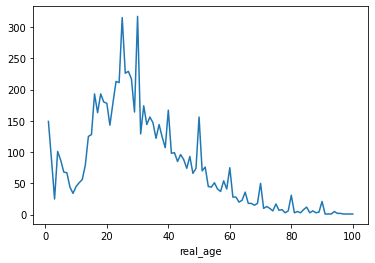

In [31]:
 #Distribucion de edades
labels.groupby('real_age')['real_age'].count().plot()
    


In [32]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [33]:
 labels['real_age'].unique()

array([  4,  18,  80,  50,  17,  27,  24,  43,  26,  39,  51,   2,   1,
         6,   5,  40,  16,  29,  35,  25,  30,  65,  13,  28,  31,  10,
        34,  15,   8,  20,  19,  42,  23,  58,  44,   7,  21,  14,  48,
        45,  37,  22,  59,  53,   9,  41,  32,  60,  38,  54,  49,  36,
        11,  70,  52,  33,  72,  47,  46,  55,  63,  12,  56,   3,  68,
        64,  67,  62,  57,  75,  61,  69,  90,  85,  88,  73,  71,  83,
        84,  87,  66,  82,  86,  77, 100,  79,  78,  76,  94,  89,  74,
        97,  93,  81,  95,  96,  91])

In [34]:
#Carga de fotos


train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


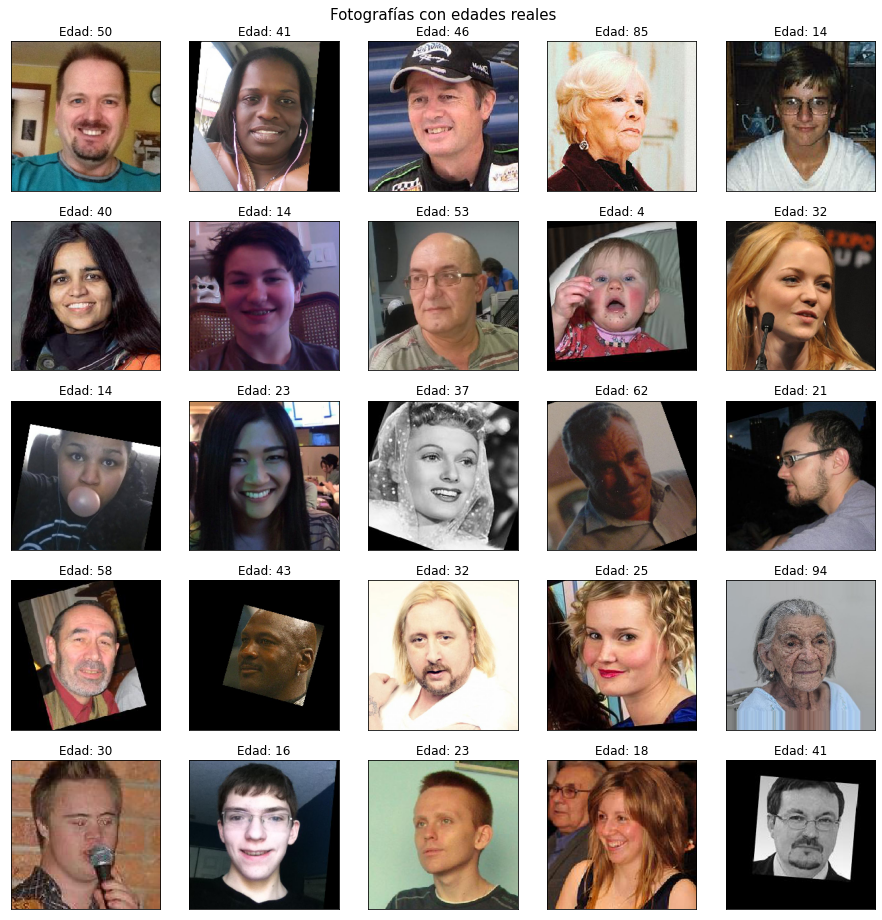

In [35]:
##observacion de fotos de distintas edades
# Se establece el tamaño de la figura

fig = plt.figure(figsize=(13,13))

# Construimos un bucle que devolverá 25 imágenes con sus edades reales respectivas
for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title(f'Edad: {target[i]}')
    # quitamos los ejes y colocamos las imágenes cerca para obtener un output más compacto
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Fotografías con edades reales', fontsize=15)
    plt.tight_layout()

### Conclusiones

El tipo de datos es correcto y no hay ausentes

La mayoria de las fotos correspondes a personas de entre 20 y 30 años de edad, es decir que hay un gran desbalance de clases que debera tenerse en cuenta a la hora de construir el modelo

La observaion aleatoria de fotos del conjunto de datos, muestra coherencia entre la imagen y la edad


## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [36]:

def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, rotation_range=25, horizontal_flip= True)

    train_datagen_flow = datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345) 

    return  train_datagen_flow
 

In [37]:
def create_model(input_shape):
   
    optimizer = Adam(lr=0.001) #agregue cero
    backbone = ResNet50(
    input_shape=input_shape, weights='imagenet', include_top=False)


    backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())  
    
    model.add(Dense(128, activation='relu'))
   
    model.add(Dense(80, activation='relu'))
   
    model.add(Dense(1, activation='linear')) 
    model.compile(
    loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model


In [38]:
def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')

    
    datagen = ImageDataGenerator(rescale=1./255)

    val_datagen_flow = datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345) 
    
    return  val_datagen_flow
 

In [39]:

def train_model(model, train_data, test_data, batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model


### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [40]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """

import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam


def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, rotation_range=25, horizontal_flip= True)

    train_datagen_flow = datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345) 

    return  train_datagen_flow
    
def create_model(input_shape):
   
    optimizer = Adam(lr=0.001) #agregue cero
    backbone = ResNet50(
    input_shape=input_shape, weights='imagenet', include_top=False)


    backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())  
    
    model.add(Dense(128, activation='relu'))
   
    model.add(Dense(80, activation='relu'))
   
    model.add(Dense(1, activation='linear')) 
    model.compile(
    loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')

    
    datagen = ImageDataGenerator(rescale=1./255)

    val_datagen_flow = datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345) 
    
    return  val_datagen_flow

##


def train_model(model, train_data, test_data, batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model

"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

- Resultado de la plataforma GPU

Train for 238 steps
Epoch 1/30
2023-09-02 23:59:21.974198: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-02 23:59:22.395418: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
238/238 - 111s - loss: 247.6630 - mae: 12.1037
Epoch 2/30
238/238 - 108s - loss: 175.4311 - mae: 10.2307
Epoch 3/30
238/238 - 109s - loss: 159.8908 - mae: 9.6886
Epoch 4/30
238/238 - 108s - loss: 142.9256 - mae: 9.1353
Epoch 5/30
238/238 - 108s - loss: 133.3970 - mae: 8.8546
Epoch 6/30
238/238 - 109s - loss: 135.3227 - mae: 8.8992
Epoch 7/30
238/238 - 109s - loss: 128.7123 - mae: 8.6917
Epoch 8/30
238/238 - 108s - loss: 125.8895 - mae: 8.5236
Epoch 9/30
238/238 - 109s - loss: 120.9754 - mae: 8.4511
Epoch 10/30
238/238 - 109s - loss: 118.8202 - mae: 8.3377
Epoch 11/30
238/238 - 109s - loss: 113.1438 - mae: 8.1316
Epoch 12/30
238/238 - 109s - loss: 111.5029 - mae: 8.0764
Epoch 13/30
238/238 - 116s - loss: 109.8012 - mae: 7.9456
Epoch 14/30
238/238 - 116s - loss: 107.3404 - mae: 7.8799
Epoch 15/30
238/238 - 116s - loss: 103.8532 - mae: 7.8167
Epoch 16/30
238/238 - 116s - loss: 97.7468 - mae: 7.5300
Epoch 17/30
238/238 - 111s - loss: 100.3032 - mae: 7.6355
Epoch 18/30
238/238 - 108s - loss: 93.0745 - mae: 7.4120
Epoch 19/30
238/238 - 109s - loss: 89.6174 - mae: 7.2849
Epoch 20/30
238/238 - 109s - loss: 88.0977 - mae: 7.2213
Epoch 21/30
238/238 - 109s - loss: 87.1270 - mae: 7.1624
Epoch 22/30
238/238 - 109s - loss: 87.2393 - mae: 7.1700
Epoch 23/30
238/238 - 109s - loss: 83.3907 - mae: 7.0019
Epoch 24/30
238/238 - 109s - loss: 80.9636 - mae: 6.9536
Epoch 25/30
238/238 - 109s - loss: 80.6535 - mae: 6.8941
Epoch 26/30
238/238 - 115s - loss: 76.6294 - mae: 6.7639
Epoch 27/30
238/238 - 116s - loss: 73.4451 - mae: 6.6251
Epoch 28/30
238/238 - 116s - loss: 72.8720 - mae: 6.5931
Epoch 29/30

## Conclusiones

 - En la epoca 23 se obtiene el primer valor de EAM menor a 7
    